In [35]:
# Declare data visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
%matplotlib inline
# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()
from datetime import datetime
# Declare libraries that initialize layers for the LSTM model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
# Declare libraries that instantiate different models for comparison
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# Declare model evaluation libraries
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Mô hình mạng bộ nhớ dài–ngắn LSTM (Long Short Term Memory)


In [36]:
# Get the stock quote
df = pdr.get_data_yahoo('AAPL', start='2012-01-01', end='2024-07-27')
# Show data
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.416983,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.483714,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.622307,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.754257,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.734028,394024400
...,...,...,...,...,...,...
2024-07-22,227.009995,227.779999,223.089996,223.960007,223.960007,48201800
2024-07-23,224.369995,226.940002,222.679993,225.009995,225.009995,39960300
2024-07-24,224.000000,224.800003,217.130005,218.539993,218.539993,61777600


In [37]:
# Summary Stats
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3.161000e+03
mean,73.525597,74.307428,72.782013,73.574134,71.435214,1.858117e+08
std,60.248385,60.902360,59.639833,60.296094,60.810330,1.676805e+08
min,13.856071,14.271429,13.753571,13.947500,11.966007,2.404830e+07
25%,25.195000,25.450001,25.047501,25.254999,22.772299,8.322110e+07
50%,43.125000,43.529999,42.794998,43.125000,40.937935,1.261612e+08
75%,133.419998,134.669998,131.619995,133.190002,131.112564,2.231640e+08
max,236.479996,237.229996,233.089996,234.820007,234.820007,1.506120e+09


In [38]:
# General info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3161 entries, 2012-01-03 to 2024-07-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3161 non-null   float64
 1   High       3161 non-null   float64
 2   Low        3161 non-null   float64
 3   Close      3161 non-null   float64
 4   Adj Close  3161 non-null   float64
 5   Volume     3161 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 172.9 KB


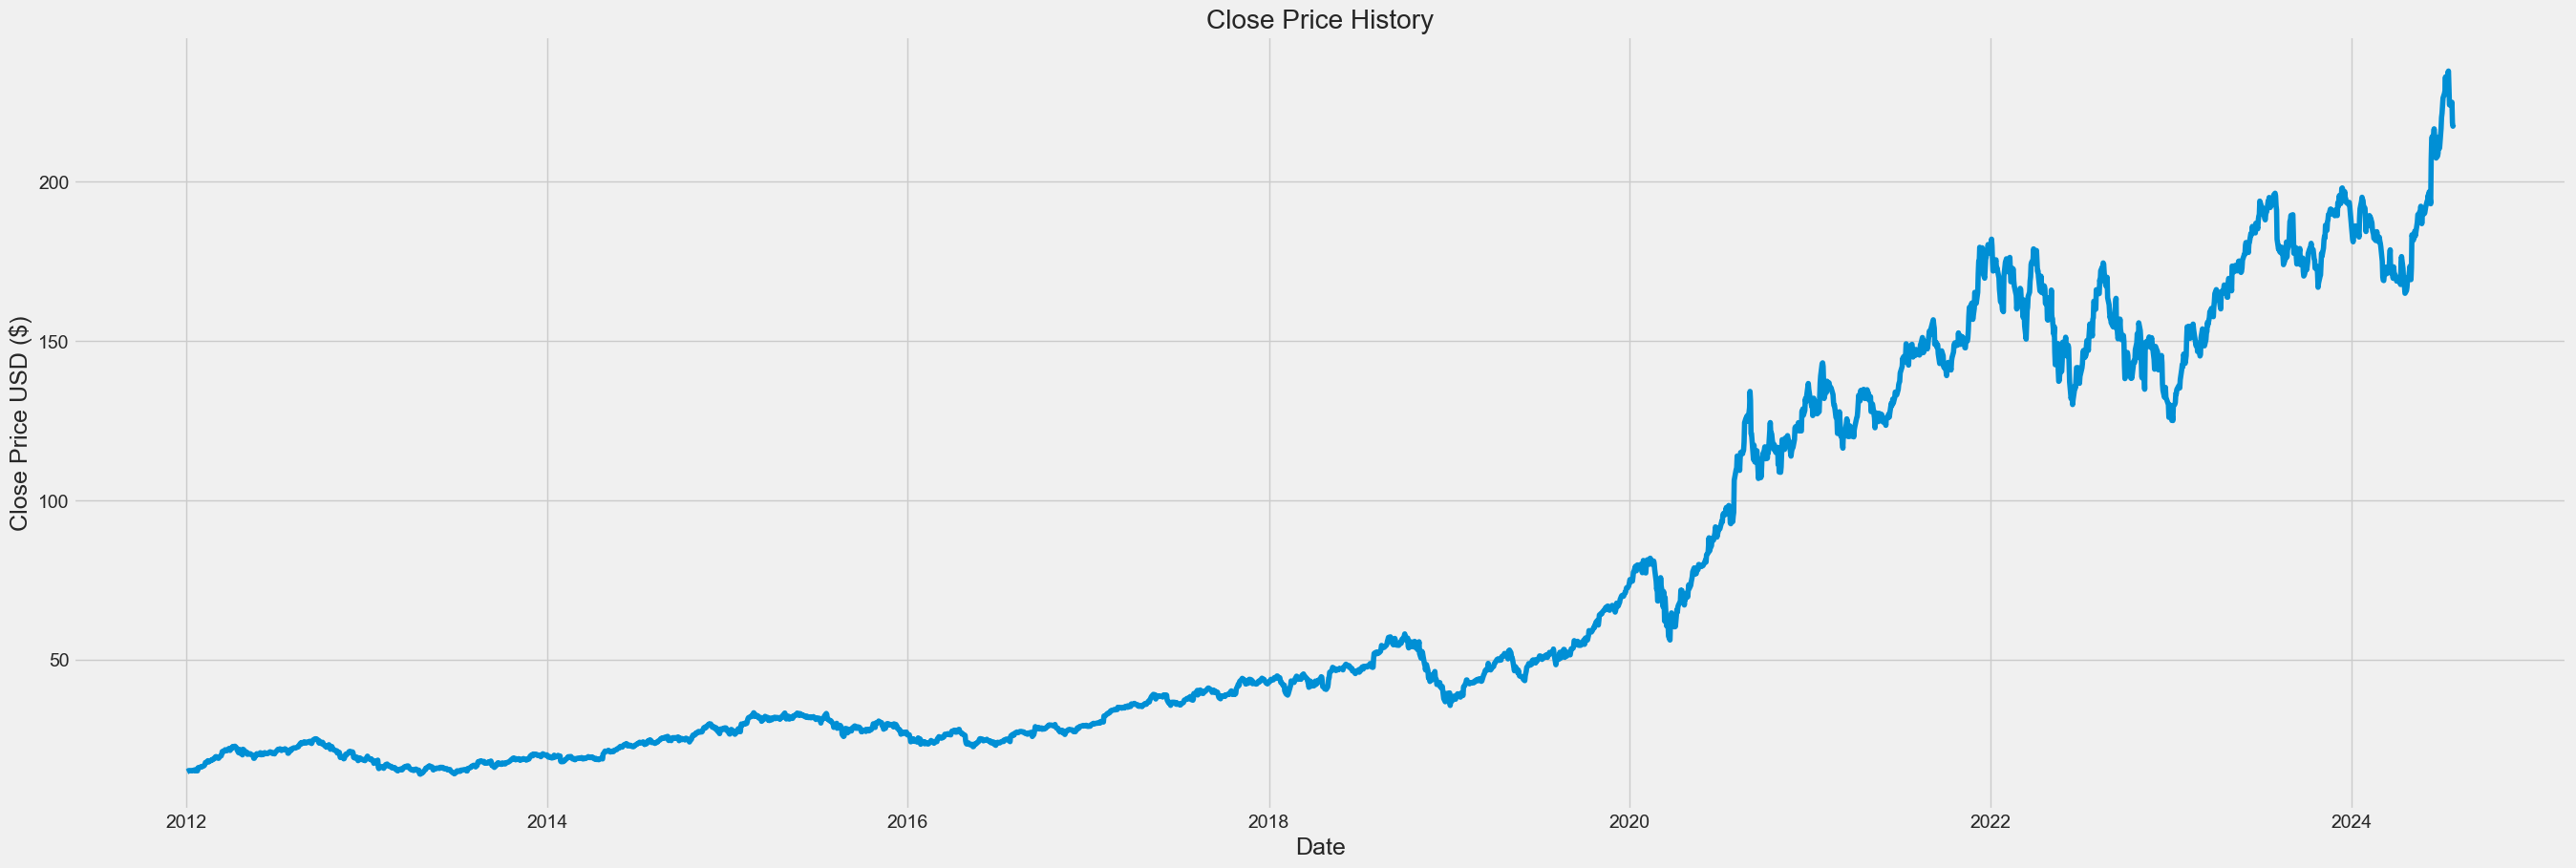

In [39]:
plt.figure(figsize=(30,10))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [40]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * 0.95))


In [41]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00334711],
       [0.00370446],
       [0.00444665],
       ...,
       [0.92629226],
       [0.92153844],
       [0.92366637]])

In [42]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

[array([0.00334711, 0.00370446, 0.00444665, 0.00515326, 0.00504493,
       0.00528909, 0.00517752, 0.00498995, 0.00473447, 0.00552516,
       0.00623825, 0.00601834, 0.0048137 , 0.00596336, 0.00483149,
       0.00907602, 0.00874778, 0.00917627, 0.01010279, 0.01066387,
       0.01061698, 0.01044397, 0.0111813 , 0.01187498, 0.01266083,
       0.01393014, 0.01659652, 0.01663694, 0.01812132, 0.01923055,
       0.01732415, 0.01805825, 0.0180437 , 0.0201021 , 0.01980942,
       0.0203511 , 0.02132451, 0.0218662 , 0.02342657, 0.02456329,
       0.02489154, 0.02500635, 0.02306276, 0.02259383, 0.02266337,
       0.02449054, 0.02500473, 0.02610912, 0.02871243, 0.03218567,
       0.03153564, 0.03153726, 0.03404841, 0.03483426, 0.03427478,
       0.03376382, 0.03323184, 0.03499918, 0.03621191, 0.03671963])]
[0.03546486572351548]

[array([0.00334711, 0.00370446, 0.00444665, 0.00515326, 0.00504493,
       0.00528909, 0.00517752, 0.00498995, 0.00473447, 0.00552516,
       0.00623825, 0.00601834, 0.00

(2943, 60, 1)

In [43]:
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size=128, epochs=200,validation_split=0.2)

Epoch 1/200


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 157ms/step - loss: 0.0158 - val_loss: 0.0016
Epoch 2/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - loss: 5.1129e-04 - val_loss: 0.0012
Epoch 3/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - loss: 2.1914e-04 - val_loss: 0.0011
Epoch 4/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - loss: 1.7406e-04 - val_loss: 0.0012
Epoch 5/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - loss: 1.7368e-04 - val_loss: 0.0011
Epoch 6/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - loss: 1.5103e-04 - val_loss: 0.0013
Epoch 7/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 1.7069e-04 - val_loss: 0.0011
Epoch 8/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - loss: 1.4809e-04 - val_loss: 0.0013
Epoch 9/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 1.4998e-04 - val_loss: 0.0013
Epoch 10/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - loss: 1.4966e-04 - val_loss: 0.0025
Epoch 11/200
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - loss: 2.0463e-04 - val_loss: 9.5719e-04
Epoch 12/

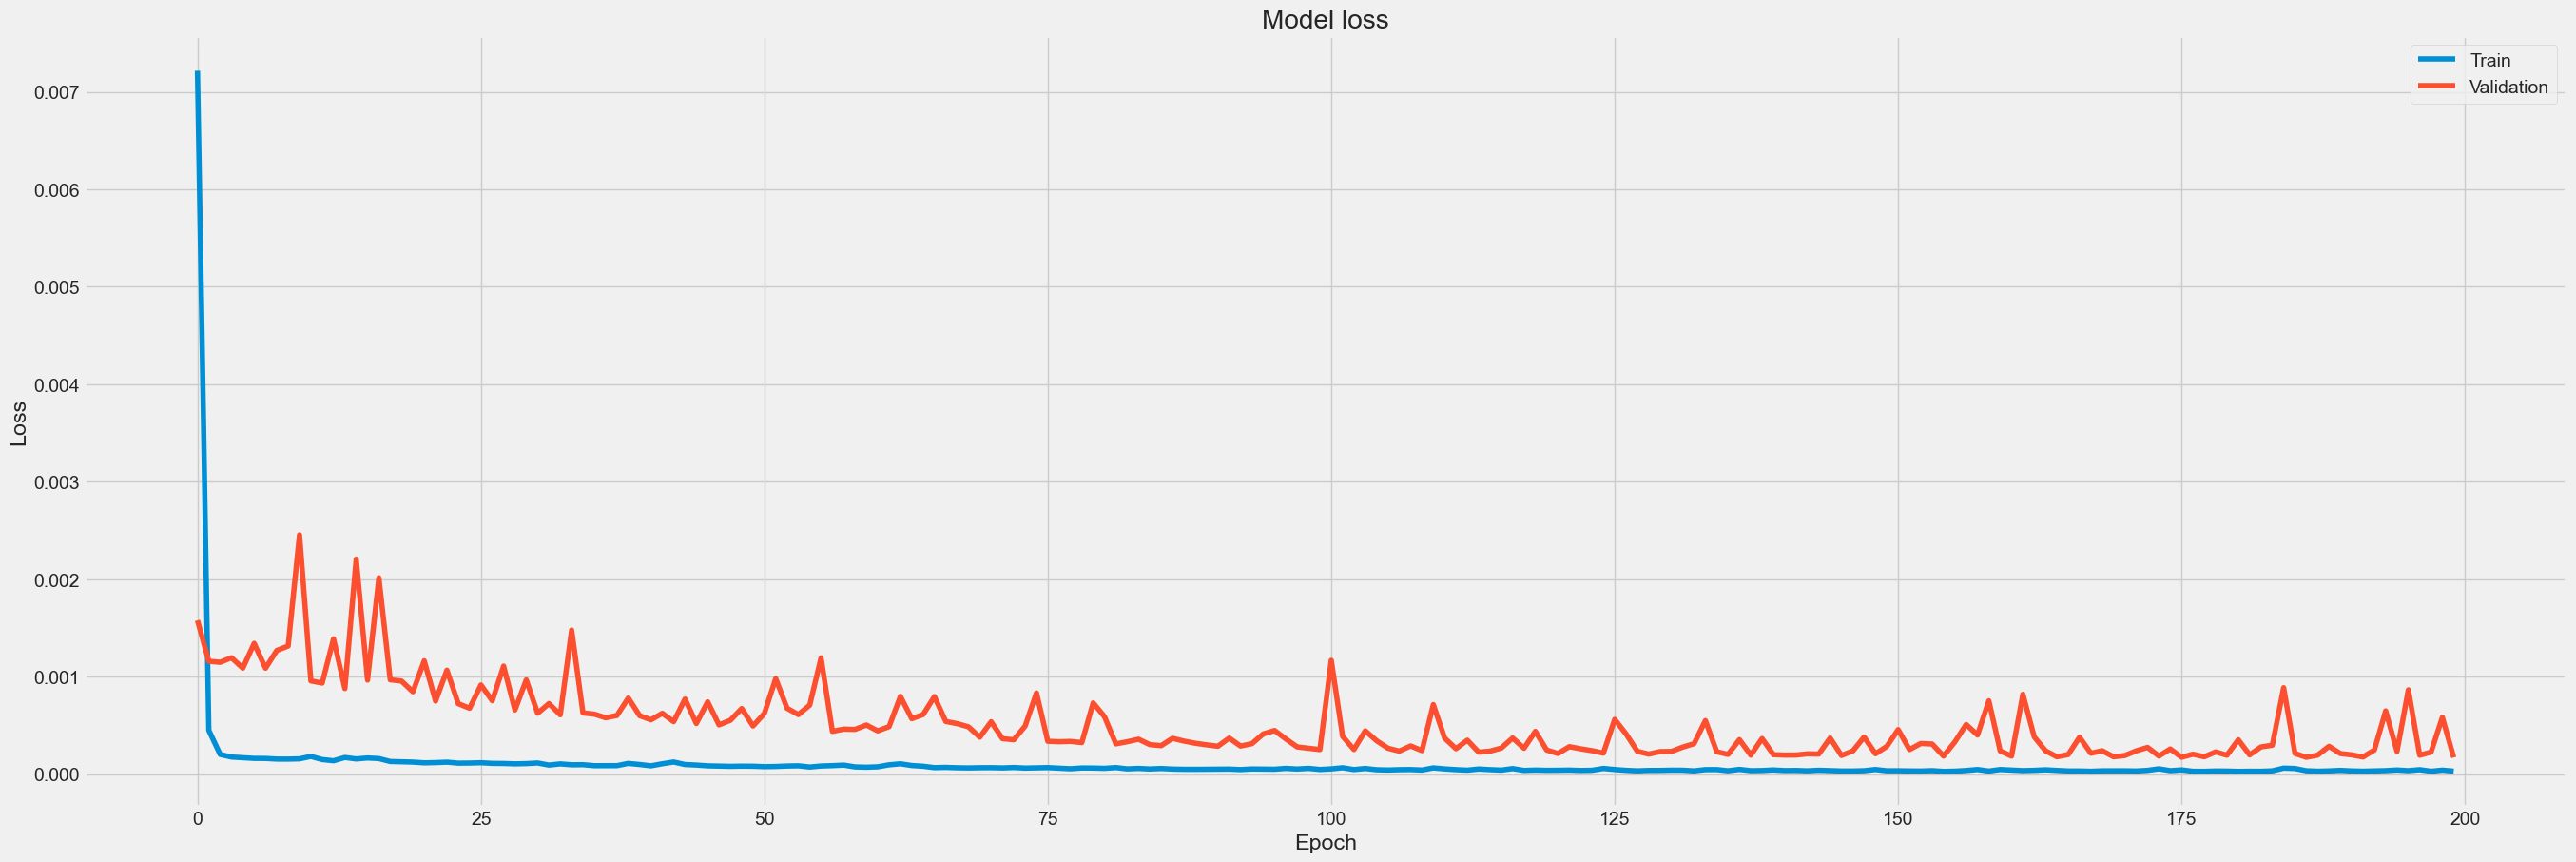

In [44]:
# Plot training & validation loss values
plt.figure(figsize=(30, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [45]:
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions


1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x345ce9d00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[192.27588],
       [193.72134],
       [190.24281],
       [192.74654],
       [196.50398],
       [195.6639 ],
       [194.87671],
       [193.19893],
       [195.01656],
       [192.29626],
       [192.57124],
       [191.45285],
       [190.96506],
       [191.21828],
       [191.63242],
       [190.1829 ],
       [182.25308],
       [182.39745],
       [180.39479],
       [179.83917],
       [185.05334],
       [183.52023],
       [184.39255],
       [183.67154],
       [184.20703],
       [181.70122],
       [181.18651],
       [188.56131],
       [190.82956],
       [192.49272],
       [193.56584],
       [192.58511],
       [192.54965],
       [190.82317],
       [190.55045],
       [186.48616],
       [183.04579],
       [186.87982],
       [185.0809 ],
       [186.92381],
       [188.36662],
       [187.84422],
       [186.4238 ],
       [187.35875],
       [185.3765 ],
       [183.26836],
       [182.86569],
       [182.82535],
       [181.05116],
       [180.43906],


/var/folders/1c/h3mcrjs96pxbb_6hcly26ygm0000gn/T/ipykernel_26489/2503389649.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


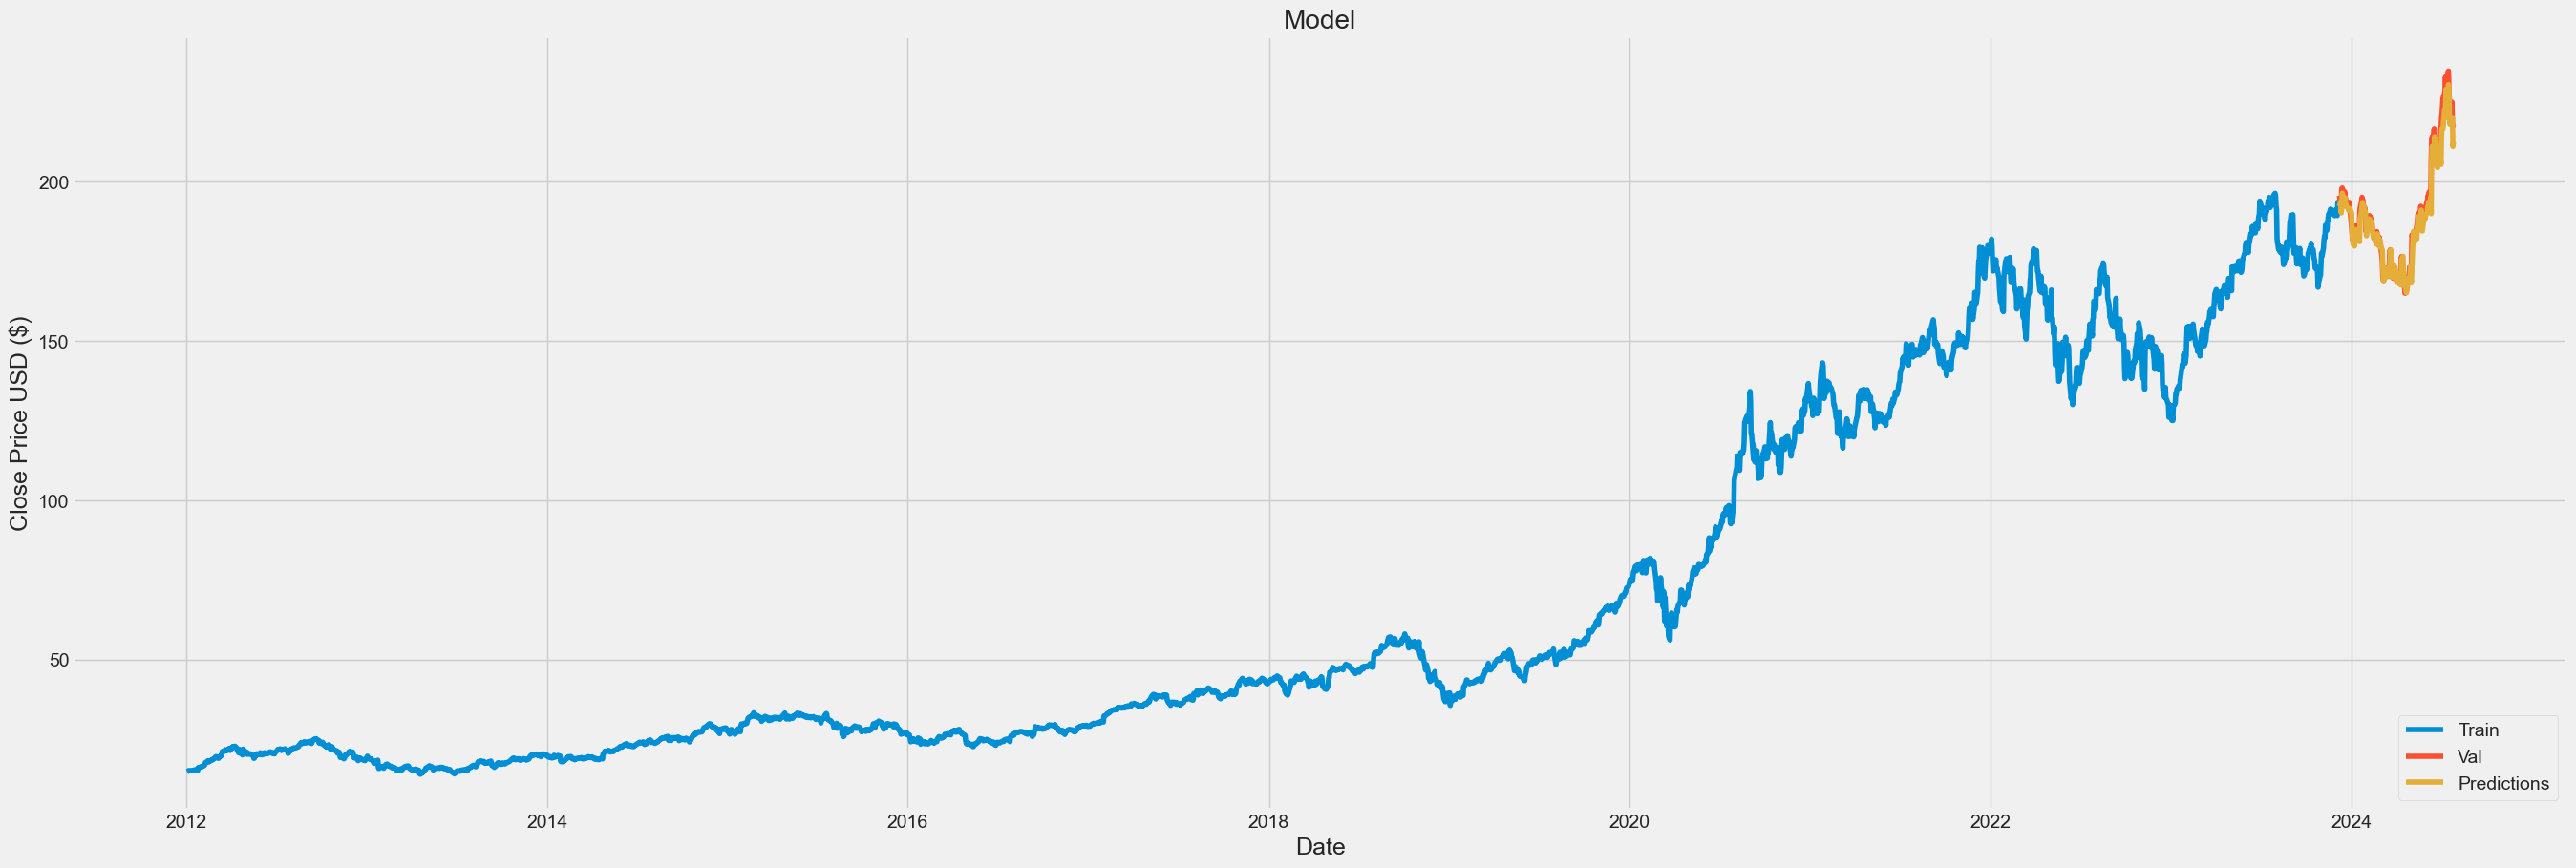

In [46]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions 
# Visualize the data
plt.figure(figsize=(30,10))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [47]:
# Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2023-12-08,195.710007,192.275879
2023-12-11,193.179993,193.721344
2023-12-12,194.710007,190.242813
2023-12-13,197.960007,192.746536
2023-12-14,198.110001,196.503983
...,...,...
2024-07-22,223.960007,220.233643
2024-07-23,225.009995,219.090378
2024-07-24,218.539993,220.217911


# Mô hình hồi quy tuyến tính (Linear Regression)

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# Chuẩn bị dữ liệu
data = df.filter(['Close'])
dataset = data.values

# Tạo độ dài dữ liệu huấn luyện
training_data_len = int(np.ceil(len(dataset) * .95))

# Chia dữ liệu thành tập huấn luyện và kiểm tra
train_data = dataset[:training_data_len, :]
test_data = dataset[training_data_len- 60:, :]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)

# Tạo tập dữ liệu huấn luyện và kiểm tra cho các mô hình khác
X_train = np.array([scaled_train_data[i-60:i, 0] for i in range(60, len(scaled_train_data))])
y_train = scaled_train_data[60:, 0]

X_test = np.array([scaled_test_data[i-60:i, 0] for i in range(60, len(scaled_test_data))])
y_test = test_data[60:]
training_data_len

3003

In [49]:
# Xây dựng và huấn luyện mô hình hồi quy tuyến tính
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Dự đoán giá trị
lr_predictions = lr_model.predict(X_test)
lr_predictions = scaler.inverse_transform(lr_predictions.reshape(-1, 1))
print(lr_predictions.shape) 

(158, 1)


# Mô hình Rừng ngẫu nhiên (Random Forest)

In [50]:
# Xây dựng và huấn luyện mô hình Random Forest
rf_model = RandomForestRegressor(n_estimators=200)
rf_model.fit(X_train, y_train)

# Dự đoán giá trị
rf_predictions = rf_model.predict(X_test)
rf_predictions = scaler.inverse_transform(rf_predictions.reshape(-1, 1))
print(rf_predictions.shape)


(158, 1)


+---+-------------------+--------------------+--------------------+--------------------+---------------------+
|   |       Model       |        MAE         |        MSE         |        RMSE        |         R2          |
+---+-------------------+--------------------+--------------------+--------------------+---------------------+
| 0 |       LSTM        | 2.6734211595752573 | 13.785848103056933 | 3.712929854314101  | 0.9553788602127458  |
| 1 | Linear Regression | 2.155970816020217  | 8.592123920031863  | 2.9312324916375814 | 0.9721895700838211  |
| 2 |   Random Forest   | 7.376095512003862  | 176.77079989210202 | 13.295518037748737 | 0.42783973003872167 |
+---+-------------------+--------------------+--------------------+--------------------+---------------------+


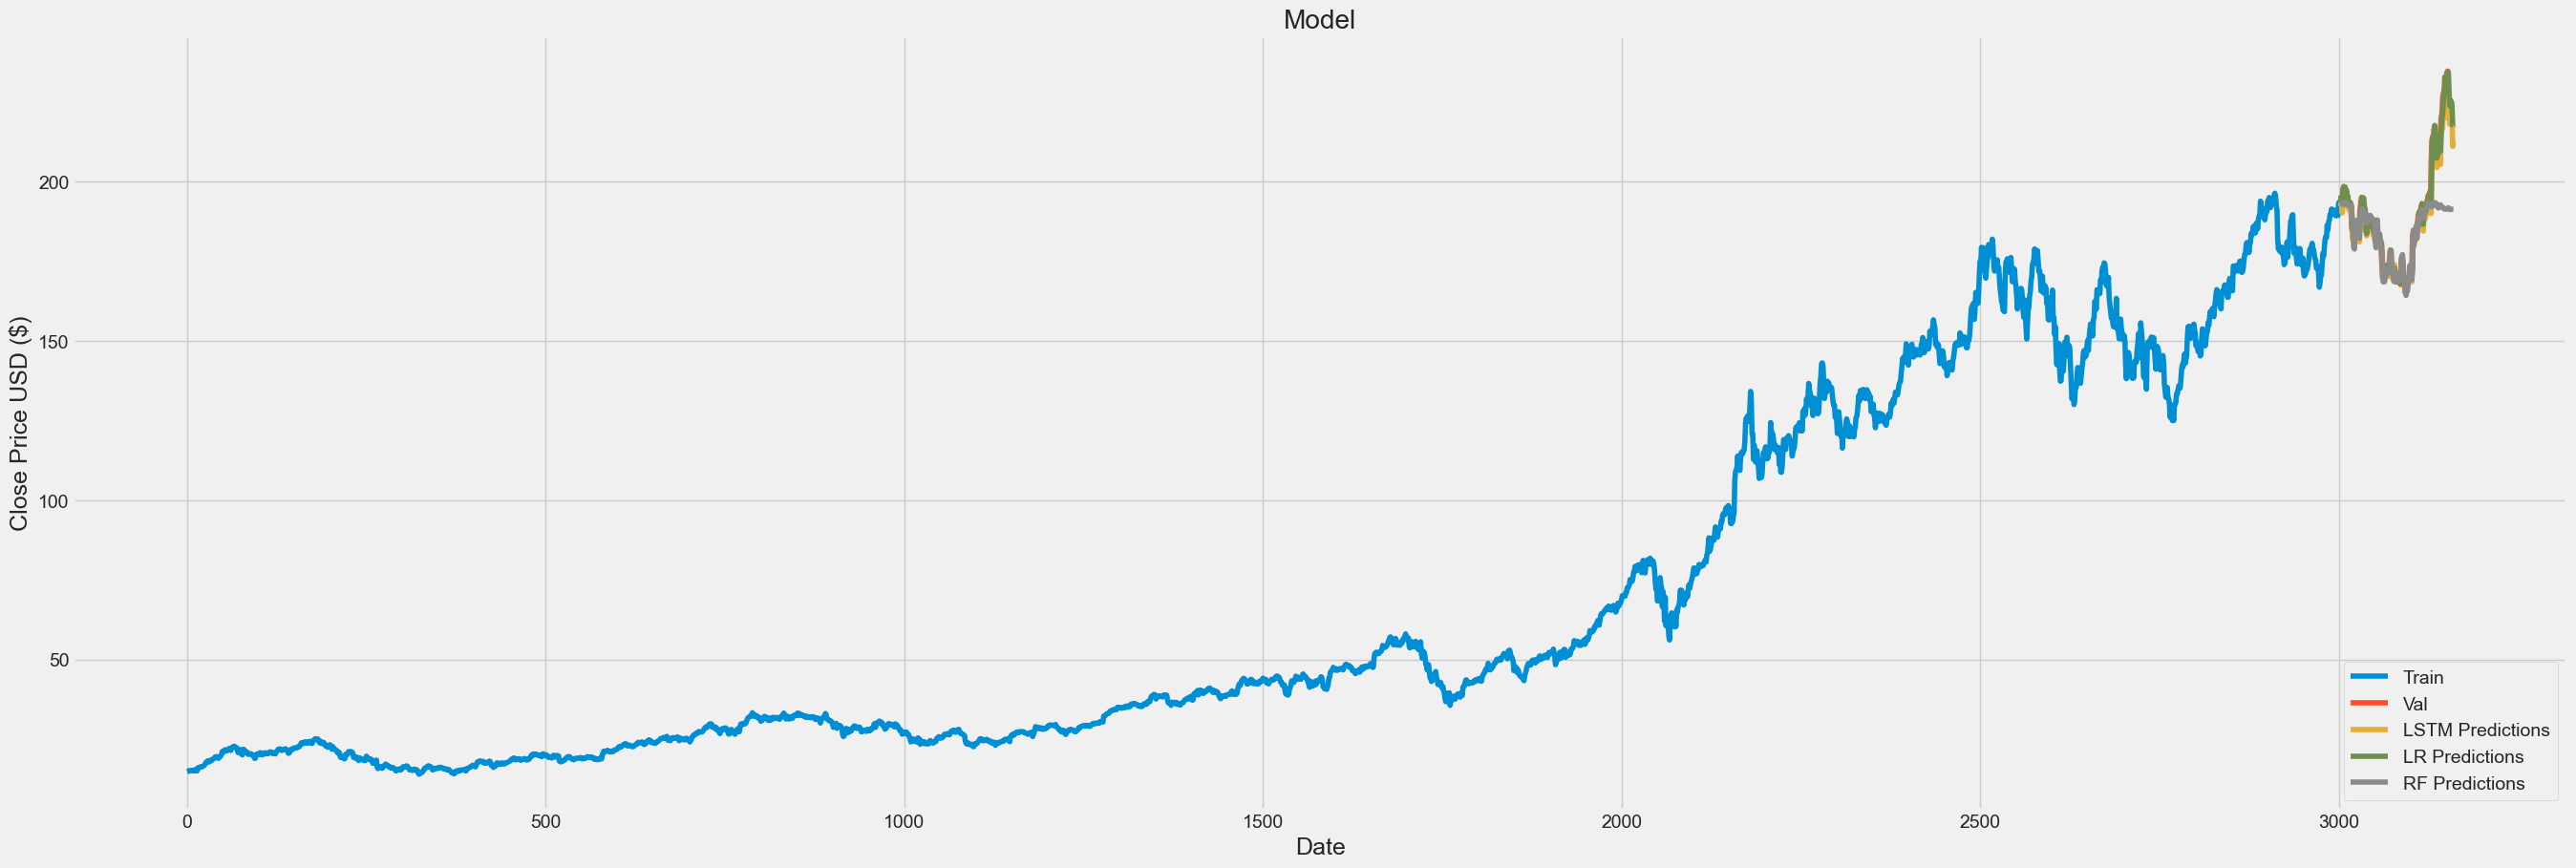

In [51]:
from tabulate import tabulate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#Evaluate the LSTM model
mae_lstm = mean_absolute_error(y_test, predictions) 
mse_lstm = mean_squared_error(y_test, predictions)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, predictions)
# Evaluate the Linear Regression model
mae_lr = mean_absolute_error(y_test, lr_predictions)
mse_lr = mean_squared_error(y_test, lr_predictions)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test,lr_predictions)
# Evaluate the Random Forest model
mae_rf = mean_absolute_error(y_test, rf_predictions)
mse_rf = mean_squared_error(y_test, rf_predictions)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test,rf_predictions)

# Create a DataFrame for the evaluation metrics
metrics = {
    "Model": ["LSTM", "Linear Regression", "Random Forest"],
    "MAE": [mae_lstm, mae_lr, mae_rf],
    "MSE": [mse_lstm, mse_lr, mse_rf],
    "RMSE": [rmse_lstm, rmse_lr, rmse_rf],
    "R2": [r2_lstm,r2_lr,r2_rf]
}

metrics_df = pd.DataFrame(metrics)

# Display the DataFrame
print(tabulate(metrics_df, headers='keys', tablefmt='pretty'))

# Plot the data
plt.figure(figsize=(30, 10))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train_data[:, 0], label='Train')
plt.plot(np.arange(training_data_len, training_data_len + len(y_test)), y_test, label='Val')
plt.plot(np.arange(training_data_len, training_data_len + len(predictions)), predictions, label='LSTM Predictions')
plt.plot(np.arange(training_data_len, training_data_len + len(lr_predictions)), lr_predictions, label='LR Predictions')
plt.plot(np.arange(training_data_len, training_data_len + len(rf_predictions)), rf_predictions, label='RF Predictions')
plt.legend(loc='lower right')
plt.show()